In [ ]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
# ganti nama file dari hasil tahap normalisasi sebelumnya
file = pd.read_csv('OUT_ALL_TELKOMSEL.csv', delimiter=',')

In [ ]:
len(file)

1740

In [ ]:
# ganti nama file_input dengan file .txt file asli dari hasil preprocessing
file_input = "telkomsel-labelled.txt"
file_txt = open(file_input, mode='r', encoding='utf-8')
text = file_txt.readlines()

In [ ]:
len(text)

1073

In [ ]:
file['tweet_id'].mode()[0]

937

In [ ]:
# Code untuk mencari fitur POS
list_feature = []

for idx, t in enumerate(text):
    selected = file[file['tweet_id'] == idx]
    list_tweet = []
    
    if len(selected.index) > 0:
        for a, tweet in selected.iterrows():
            feature = float(tweet['normalize_weight'])
            list_tweet.append(feature)
            
            
        if len(selected.index) < pd.value_counts(file['tweet_id']).max():
            b = len(selected.index)
            while b < pd.value_counts(file['tweet_id']).max():
                feature = float(0)
                b += 1
                list_tweet.append(feature)

        
    elif len(selected.index) == 0:
        i = 0
        while i < pd.value_counts(file['tweet_id']).max():
            feature = float(0)
            list_tweet.append(feature)
            i += 1
            
    list_feature.append(list_tweet)
    
data = np.array(list_feature)
#data = sparse.csr_matrix(sX)

# format dimenasi yang didapat menggunakan fitur POS
print(data)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.02 0.16 0.32 ... 0.   0.   0.  ]
 [0.17 0.25 0.25 ... 0.   0.   0.  ]
 [0.75 0.25 0.25 ... 0.   0.   0.  ]]


In [ ]:
# mencari label tweetnya dari file .txt hasil preprocessing
lt = []

for i,t in enumerate(text):
    a = t.split(',')
    label_y = a[1]
    label_y = label_y.split('\n')
    lt.append(label_y[0])

label_target = np.array(lt)
# label_target = sparse.csr_matrix(sY.astype(float))

In [ ]:
cn = 0
for i in label_target:
    if i == '1':
        cn += 1
neg = len(label_target)-cn
print('positif: ',cn)
print('negatif: ', neg)

positif:  324
negatif:  749


In [ ]:
with open('rank.csv', 'a') as rank:
    # rank.writelines('provider,positif,negatif\n')
    rank.writelines('XL,'+str(cn)+',' + str(neg)+'\n')

In [ ]:
# code untuk mencari TERM PRESENCE
tp = []
df = file.drop_duplicates(subset=['term'])

print(len(df))
print(pd.value_counts(file['tweet_id']).max())

for j in text:
    tt = []
    tmp = j.split(',')
    tmp = tmp[0].split()
    for k in range(len(df['term'])):
        dd = df.iloc[k]['term']
        #print(dd)
        if any(dd in s for s in tmp):
            tt.append(float(1))
        else:
            tt.append(float(0))
    
    tp.append(tt)

term_presence = np.array(tp)

print(len(term_presence))
print(term_presence)

274
7
1073
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# code untuk menggabungkan fitur TERM PRESENCE dan POS Tagging
data_total = np.column_stack([data, term_presence])

print(data_total.shape)
print(data_total)

(1073, 281)
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.02 0.16 0.32 ... 0.   0.   1.  ]
 [0.17 0.25 0.25 ... 0.   0.   0.  ]
 [0.75 0.25 0.25 ... 0.   0.   0.  ]]


In [ ]:
# fungsi untuk menampilkan confussion matrix pada hasil klasifikasi
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Best Final Accuracy on 1 CV: 0.633
              precision    recall  f1-score   support

     Positif       0.32      0.68      0.43        44
     Negatif       0.88      0.62      0.73       171

    accuracy                           0.63       215
   macro avg       0.60      0.65      0.58       215
weighted avg       0.77      0.63      0.67       215



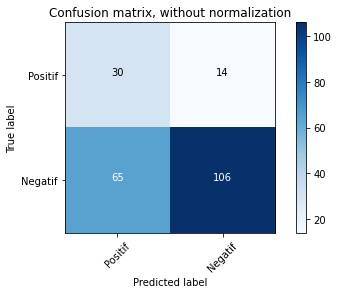

Best Final Accuracy on 2 CV: 0.805
              precision    recall  f1-score   support

     Positif       0.91      0.83      0.87       168
     Negatif       0.54      0.70      0.61        47

    accuracy                           0.80       215
   macro avg       0.73      0.77      0.74       215
weighted avg       0.83      0.80      0.81       215



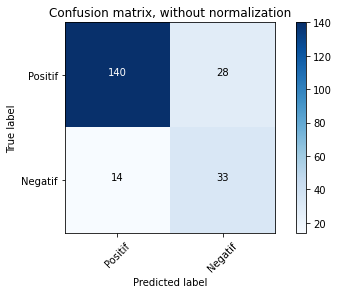

Best Final Accuracy on 3 CV: 0.716
              precision    recall  f1-score   support

     Positif       0.89      0.77      0.82       186
     Negatif       0.20      0.38      0.27        29

    accuracy                           0.72       215
   macro avg       0.55      0.57      0.54       215
weighted avg       0.80      0.72      0.75       215



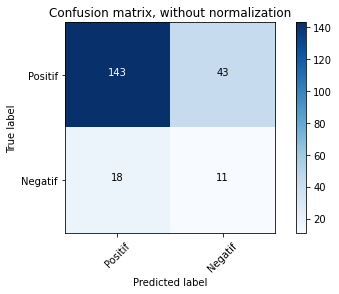

Best Final Accuracy on 4 CV: 0.790
              precision    recall  f1-score   support

     Positif       0.83      0.92      0.87       170
     Negatif       0.48      0.27      0.35        44

    accuracy                           0.79       214
   macro avg       0.66      0.60      0.61       214
weighted avg       0.76      0.79      0.77       214



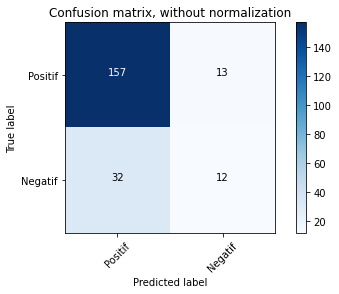

Best Final Accuracy on 5 CV: 0.729
              precision    recall  f1-score   support

     Positif       0.88      0.79      0.83       181
     Negatif       0.25      0.39      0.31        33

    accuracy                           0.73       214
   macro avg       0.57      0.59      0.57       214
weighted avg       0.78      0.73      0.75       214



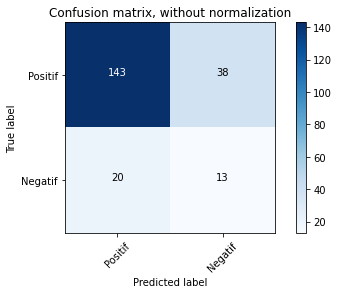

In [ ]:
# %%time
# code untuk Intelligent Model Selection
model_1 = svm.SVC(kernel='rbf')
model_2 = LogisticRegression()
model_3 = KNeighborsClassifier(n_neighbors=10)

# tunning nilai K untuk membagi jumlah dataset menjadi traning, testing, 
# dan evaluasi
skf = KFold(n_splits=5)
target_names = ['Positif','Negatif']

itter = 1
ltt = []
dtt = []
best_model_tt = []
label_best_model_tt = []
evdtt = []
evltt = []
s = []
r = []
p = []
f1 = []

for train_test_index, validation_index in skf.split(data_total, label_target):
    
    ltt.clear()
    dtt.clear()
    evdtt.clear()
    evltt.clear()
    
    # mencari label
    #print(validation_index)
    for i in train_test_index:
        ltt.append(label_target[i])
        dtt.append(data_total[i])
        
    label_testing_test = np.array(ltt)
    data_testing_test = np.array(dtt)
    
    # find best model in second cross validation with 90% data
    score2 = cross_val_score(model_3, data_testing_test, label_testing_test, cv=skf)
    
    #print all score from second CV
    #print("this is score : ", score2)
    
    # find index best score from second cross validation
    best_score_index = np.argmax(score2)
    
    #print best index model
    #print("this is best model index : ",best_score_index)
    
    counter = 0
    for f_index,g_index in skf.split(data_testing_test,label_testing_test):
        if counter == best_score_index:
            best_model_tt.clear()
            label_best_model_tt.clear()
            for c in f_index:
                best_model_tt.append(data_testing_test[c])
                label_best_model_tt.append(label_testing_test[c])       
            best_model = np.array(best_model_tt)    
            best_model_label = np.array(label_best_model_tt)
            break
        counter += 1 
    
    # save evaluation test
    for j in validation_index:
        evltt.append(label_target[j])
        evdtt.append(data_total[j])
    
    evaluation_datatest = np.array(evdtt)
    evaluation_label_datatest = np.array(evltt)
    
    # fit BEST model with evaluation
    model_3.fit(best_model, best_model_label)    
    
    #print final accuracy (done with evalution set)
    print("Best Final Accuracy on %0.0f CV: %0.3f" % (itter, model_3.score(evaluation_datatest, evaluation_label_datatest)))
    itter += 1
    
    y_predic = model_3.predict(evaluation_datatest)
    # print(y_predic)
    # print(target_names)
    # print(evaluation_label_datatest)
    
    print(classification_report(evaluation_label_datatest, y_predic, target_names=target_names))
    # print(confusion_matrix(evaluation_label_datatest, y_predic))
    
    # menghitung confusion matrix
    cnf_matrix = confusion_matrix(evaluation_label_datatest, y_predic)
    np.set_printoptions(precision=2)

    # menampilkan Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,title='Confusion matrix, without normalization')
    plt.show()
    
    # menyimpan hasil score , precision, recall, f1-score pada setiap iterasi
    s.append(model_3.score(evaluation_datatest, evaluation_label_datatest))
    p.append(precision_score(evaluation_label_datatest, y_predic, pos_label='1'))
    r.append(recall_score(evaluation_label_datatest, y_predic, pos_label='1'))
    f1.append(f1_score(evaluation_label_datatest, y_predic, pos_label='1'))
    
save_accuracy_np = np.array(s)
#print("acc : ",save_accuracy_np)

save_recall_np = np.array(r)
#print("recall : " ,save_recall_np)

save_precision_np = np.array(p)
#print("precision : ", save_precision_np)

save_f1_np = np.array(f1)
#print("f1 : " , save_f1_np)

In [ ]:
print("Accuracy: %0.3f (+/- %0.3f)" % (np.average(save_accuracy_np), np.std(save_accuracy_np)*2)) 
print("Precision: %0.3f" % (np.average(save_precision_np))) 
print("Recall: %0.3f" % (np.average(save_recall_np))) 
print("f1 score: %0.3f" % (np.average(save_f1_np)))

Accuracy: 0.734 (+/- 0.122)
Precision: 0.473
Recall: 0.474
f1 score: 0.452


In [ ]:
# cross validation normal tanpa IMS
# target_names = ['negatif', 'positif']
# clf = svm.SVC(kernel='linear')
# skf = KFold(n_splits=6)
# scores = cross_val_score(clf, data_total, label_target, cv=skf)
# predicted = cross_val_predict(clf, data_total, label_target, cv=skf)

# print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()*2))

# print(classification_report(label_target, predicted, target_names=target_names))

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.barplot(x=["IMS", "normal CV"], y=[np.average(save_accuracy_np), scores.mean()])